In [11]:
import math
import yfinance as yf
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler 
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras import layers

# Loading data
stock_data = yf.download('MSFT', start='2016-01-01', end='2021-10-01')
stock_data

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2016-01-04,54.320000,54.799999,53.389999,54.799999,48.901051,53778000
2016-01-05,54.930000,55.389999,54.540001,55.049999,49.124130,34079700
2016-01-06,54.320000,54.400002,53.639999,54.049999,48.231781,39518900
2016-01-07,52.700001,53.490002,52.070000,52.169998,46.554146,56564900
2016-01-08,52.369999,53.279999,52.150002,52.330002,46.696934,48754000
...,...,...,...,...,...,...
2021-09-24,298.230011,299.799988,296.929993,299.350006,294.645752,14999000
2021-09-27,296.140015,296.470001,292.940002,294.170013,289.547180,23571700
2021-09-28,289.799988,290.779999,282.750000,283.519989,279.064484,43186200


Text(0, 0.5, 'Prices ($)')

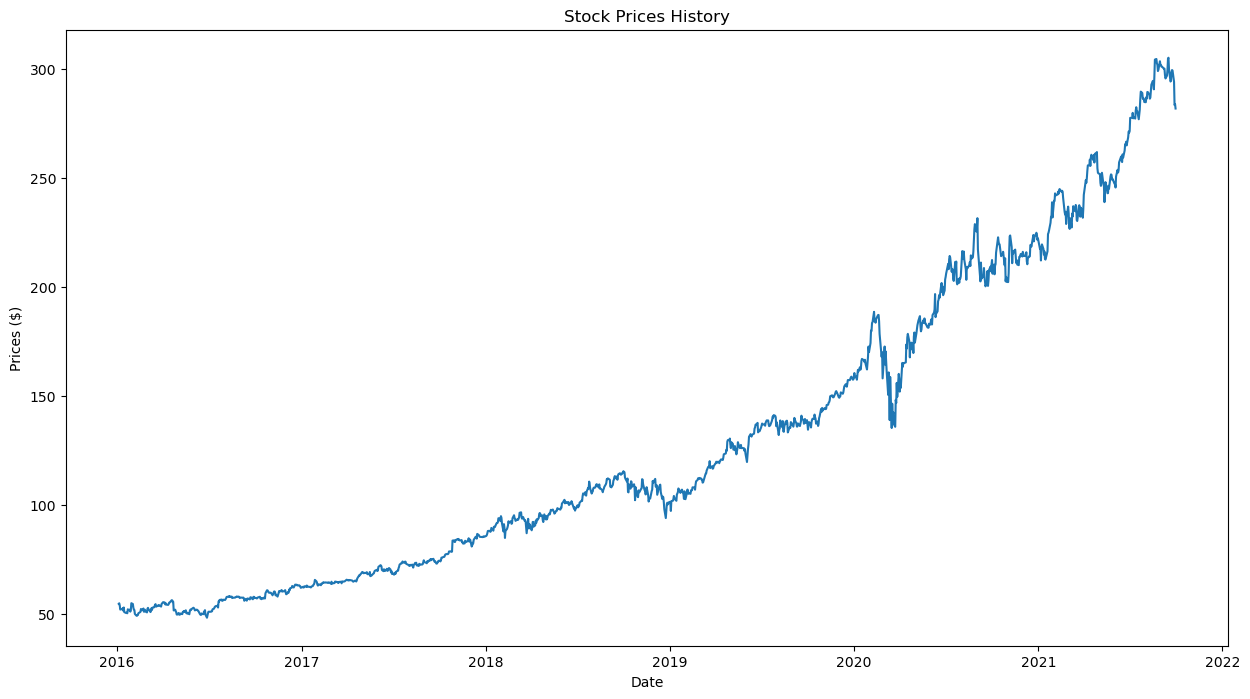

In [12]:
# visualizing stock prices history

plt.figure(figsize=(15, 8)) # Setting plot figure size
plt.title('Stock Prices History') # Setting plot figure title
plt.plot(stock_data['Close']) # Plotting a line chart for historical close prices
plt.xlabel('Date') # Set X Axis label
plt.ylabel('Prices ($)') # Set Y axis label

In [13]:
# Date Preprocessing

close_prices = stock_data['Close']
values = close_prices.values
training_data_len = math.ceil(len(values)* 0.8)

scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(values.reshape(-1,1))
train_data = scaled_data[0: training_data_len, :]

x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])
    
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [14]:
test_data = scaled_data[training_data_len-60: , : ] # picking up from where we left off in setting up the training data
x_test = []
y_test = values[training_data_len:]

for i in range(60, len(test_data)):
  x_test.append(test_data[i-60:i, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [15]:
model = keras.Sequential()
model.add(layers.LSTM(100, return_sequences=True, input_shape=(x_train.shape[1], 1))) 
model.add(layers.LSTM(100, return_sequences=False))
model.add(layers.Dense(25))
model.add(layers.Dense(1))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 60, 100)           40800     
                                                                 
 lstm_3 (LSTM)               (None, 100)               80400     
                                                                 
 dense_2 (Dense)             (None, 25)                2525      
                                                                 
 dense_3 (Dense)             (None, 1)                 26        
                                                                 
Total params: 123,751
Trainable params: 123,751
Non-trainable params: 0
_________________________________________________________________


In [16]:
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train, y_train, batch_size= 1, epochs=3)

Epoch 1/3
1098/1098 [==============================] - 18s 15ms/step - loss: 9.8696e-04
Epoch 2/3
1098/1098 [==============================] - 16s 15ms/step - loss: 3.5424e-04
Epoch 3/3
1098/1098 [==============================] - 17s 15ms/step - loss: 3.3984e-04


In [17]:
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)
rmse = np.sqrt(np.mean(predictions - y_test)**2)
rmse

10/10 [==============================] - 1s 19ms/step


4.91862371636097

/var/folders/v1/nsv9v17j7pz83_00ngtxhsnh0000gn/T/ipykernel_16224/154904543.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validation['Predictions'] = predictions


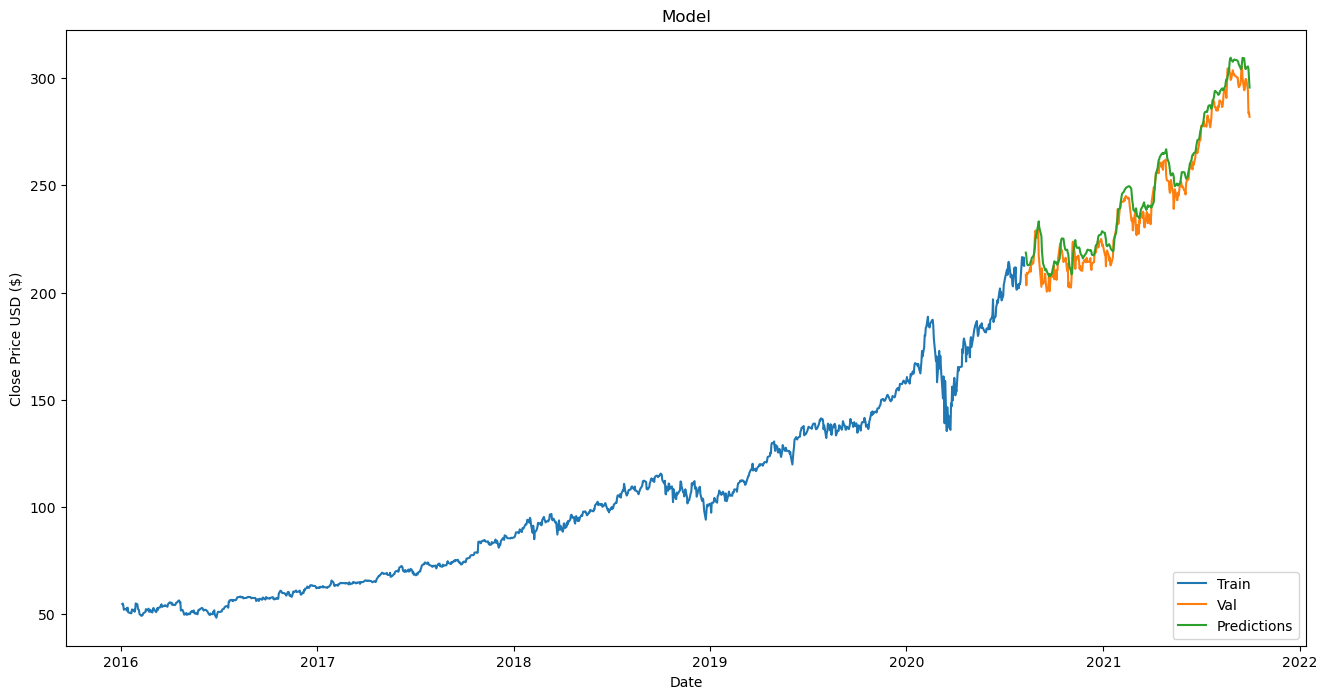

In [18]:
data = stock_data.filter(['Close'])
train = data[:training_data_len]
validation = data[training_data_len:]
validation['Predictions'] = predictions
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date')
plt.ylabel('Close Price USD ($)')
plt.plot(train)
plt.plot(validation[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()